In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from transformers import pipeline, BertTokenizer, BertModel
import torch
import seaborn as sns
from scipy.stats import shapiro, normaltest
import statsmodels.api as sm
from sklearn.preprocessing import OrdinalEncoder

In [3]:
file_path = '/kaggle/input/movie-audience-score/Rotten_Tomatoes_Movies3.xls'
df = pd.read_excel(file_path)

In [9]:
df.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,53.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,97.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,74.0



--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         16638 non-null  object        
 1   movie_info          16614 non-null  object        
 2   critics_consensus   8309 non-null   object        
 3   rating              16638 non-null  object        
 4   genre               16621 non-null  object        
 5   directors           16524 non-null  object        
 6   writers             15289 non-null  object        
 7   cast                16354 non-null  object        
 8   in_theaters_date    15823 non-null  datetime64[ns]
 9   on_streaming_date   16636 non-null  datetime64[ns]
 10  runtime_in_minutes  16483 non-null  float64       
 11  studio_name         16222 non-null  object        
 12  tomatometer_status  16638 non-null  object        
 13  tomatometer_rating  1663

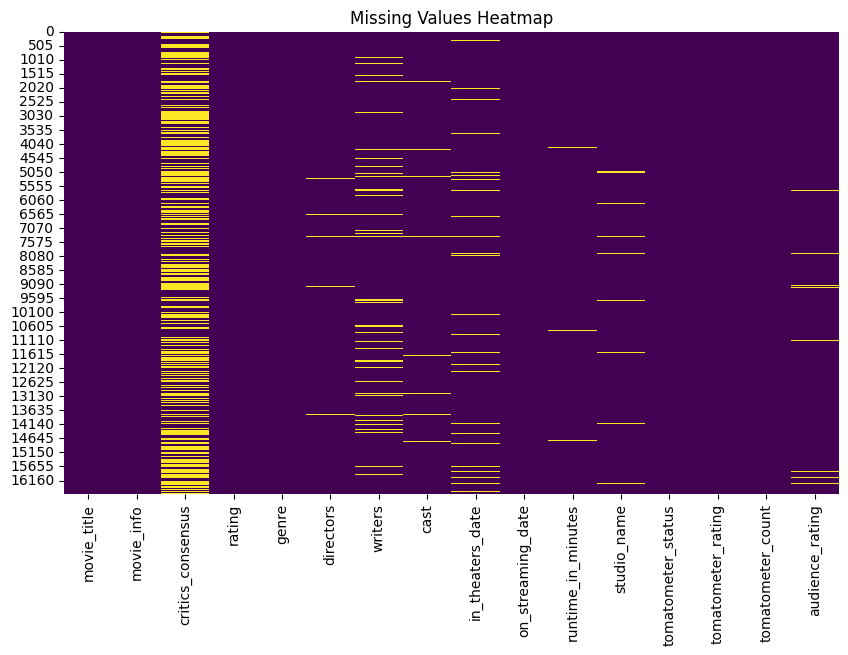

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


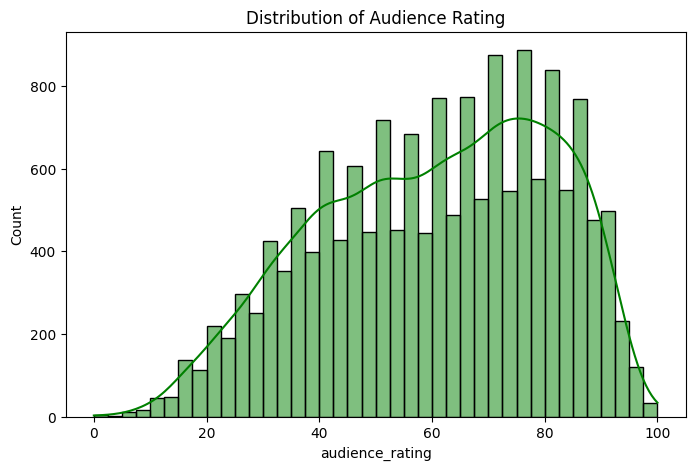

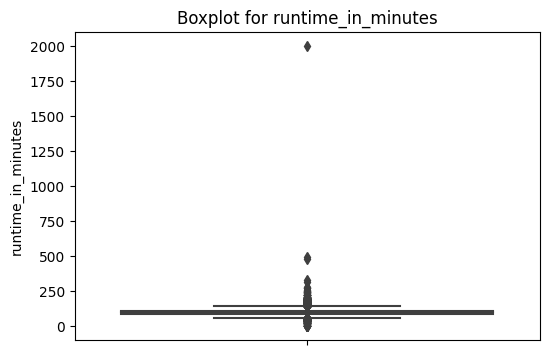

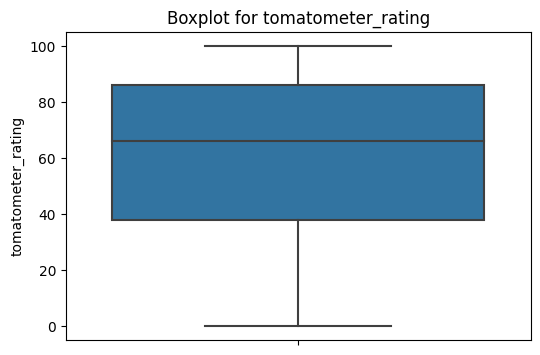

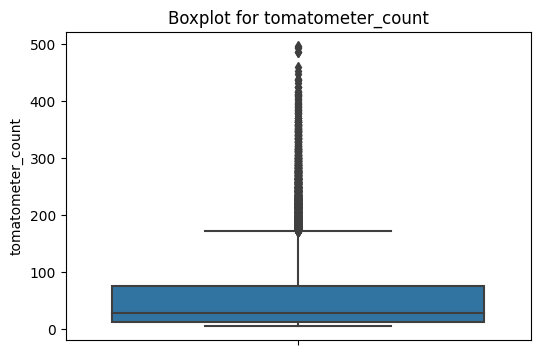

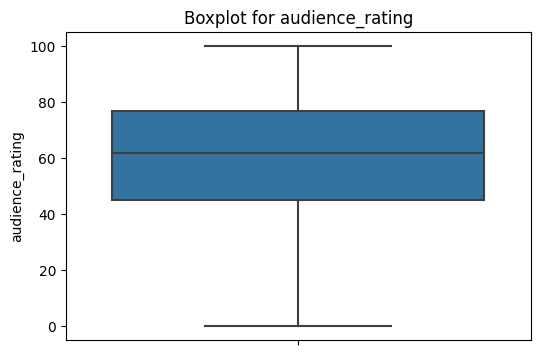

In [17]:
# Enhanced Data Exploration

"""Performs exploration and visualizes the dataset."""
print("\n--- Dataset Info ---")
print(df.info())
print("\n--- Dataset Head ---")
print(df.head())
print("\n--- Missing Values ---")
print(df.isnull().sum())
print("\n--- Descriptive Statistics ---")
print(df.describe())

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


# Distribution of Audience Rating
plt.figure(figsize=(8, 5))
sns.histplot(df['audience_rating'], kde=True, color='green')
plt.title("Distribution of Audience Rating")
plt.show()

# Boxplots for Numerical Features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()


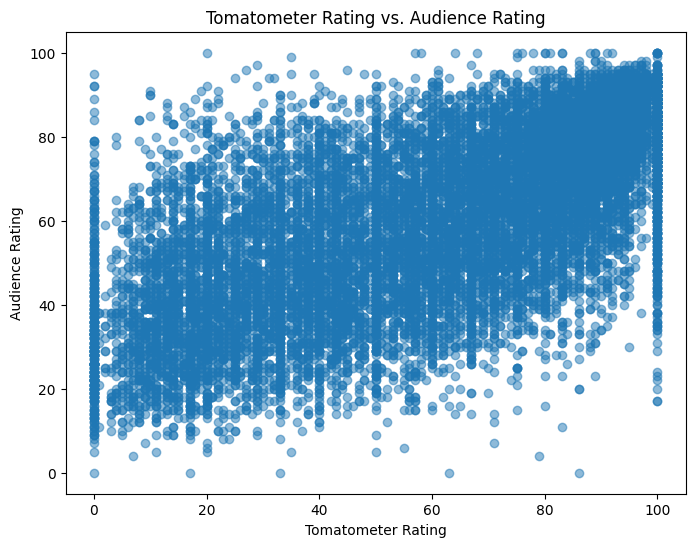

In [11]:
# @title Tomatometer Rating vs. Audience Rating
plt.figure(figsize=(8, 6))
plt.scatter(df['tomatometer_rating'], df['audience_rating'], alpha=0.5)
plt.title('Tomatometer Rating vs. Audience Rating')
plt.xlabel('Tomatometer Rating')
_ = plt.ylabel('Audience Rating')

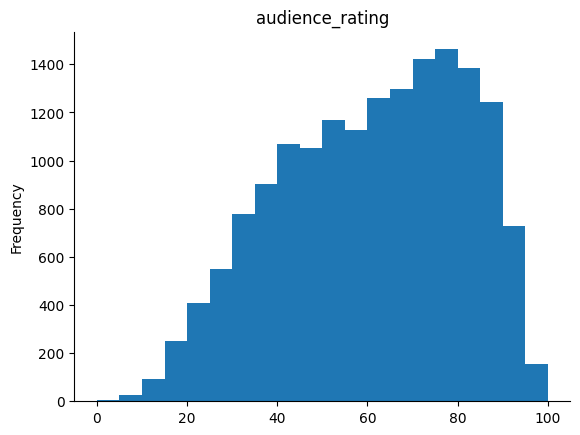

In [12]:
# @title audience_rating
df['audience_rating'].plot(kind='hist', bins=20, title='audience_rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

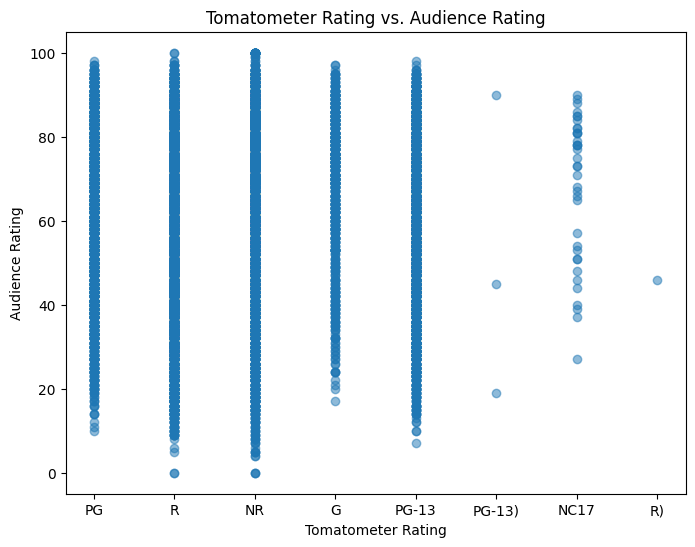

In [13]:
# @title Rating vs. Audience Rating

plt.figure(figsize=(8, 6))
plt.scatter(df['rating'], df['audience_rating'], alpha=0.5)
plt.title('Tomatometer Rating vs. Audience Rating')
plt.xlabel('Tomatometer Rating')
_ = plt.ylabel('Audience Rating')

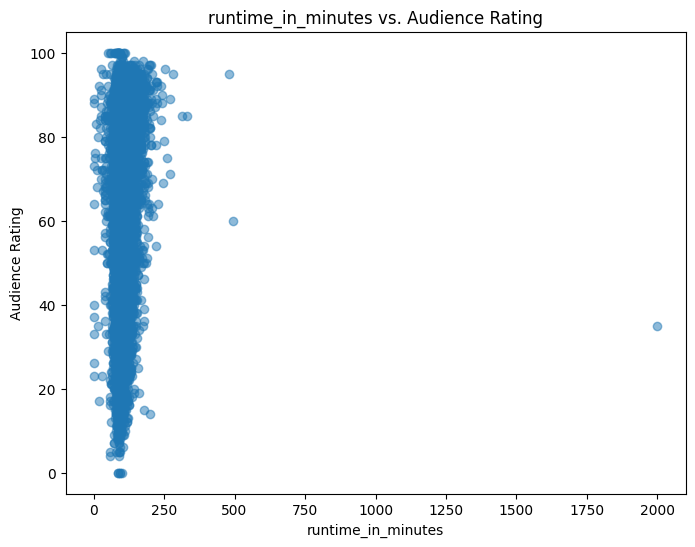

In [14]:
# @title runtime_in_minutes vs. Audience Rating

plt.figure(figsize=(8, 6))
plt.scatter(df['runtime_in_minutes'], df['audience_rating'], alpha=0.5)
plt.title('runtime_in_minutes vs. Audience Rating')
plt.xlabel('runtime_in_minutes')
_ = plt.ylabel('Audience Rating')

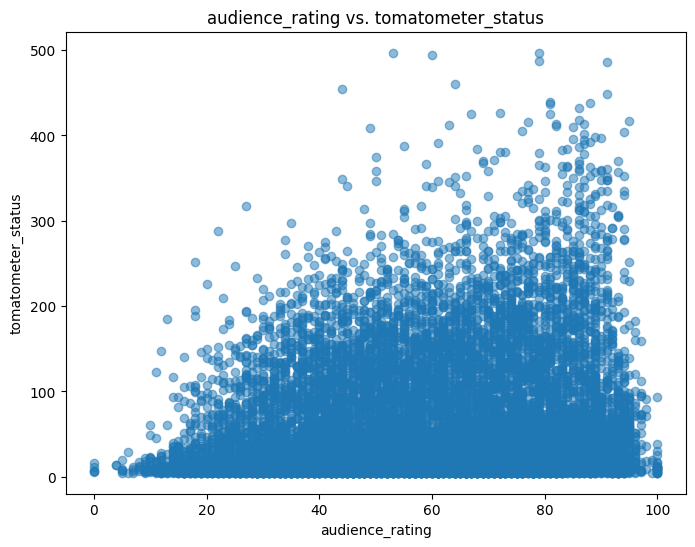

In [16]:
# @title directors vs. Audience Rating

plt.figure(figsize=(8, 6))
plt.scatter(df['audience_rating'], df['tomatometer_count'], alpha=0.5)
plt.title('audience_rating vs. tomatometer_status')
plt.xlabel('audience_rating')
_ = plt.ylabel('tomatometer_status')

In [19]:
#Testing the normality of data, for deciding to use normalization or standardisation
from scipy.stats import shapiro, normaltest
import statsmodels.api as sm

def check_normality(df, column):
    """Checks if a given column is Gaussian or not."""
    print(f"\n--- Checking Normality for '{column}' ---")

    # Histogram and KDE
    plt.figure(figsize=(8, 5))
    sns.histplot(df[column], kde=True, color='skyblue')
    plt.title(f"Histogram and KDE for {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

    # Q-Q Plot
    plt.figure(figsize=(8, 5))
    sm.qqplot(df[column], line='s')
    plt.title(f"Q-Q Plot for {column}")
    plt.show()

    # Shapiro-Wilk Test
    stat, p = shapiro(df[column])
    print(f"Shapiro-Wilk Test: Statistic={stat:.4f}, p-value={p:.4f}")
    if p > 0.05:
        print(f"The data in '{column}' appears Gaussian (fail to reject H0).")
    else:
        print(f"The data in '{column}' does NOT appear Gaussian (reject H0).")

    # D’Agostino and Pearson’s Test
    stat, p = normaltest(df[column])
    print(f"D’Agostino-Pearson Test: Statistic={stat:.4f}, p-value={p:.4f}")
    if p > 0.05:
        print(f"The data in '{column}' appears Gaussian (fail to reject H0).")
    else:
        print(f"The data in '{column}' does NOT appear Gaussian (reject H0).")



--- Checking Normality for 'audience_rating' ---


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


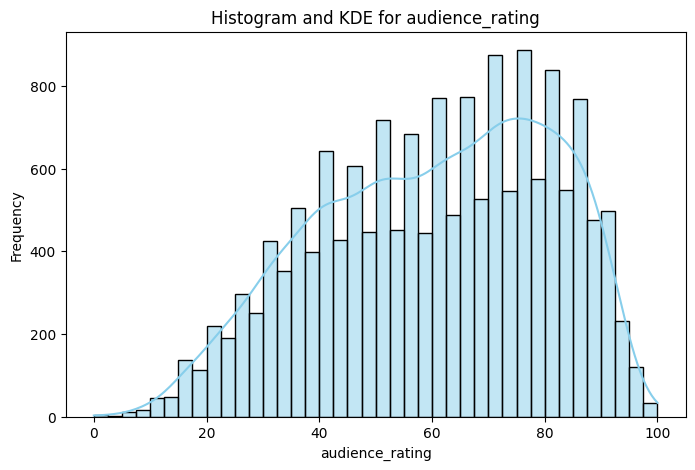

<Figure size 800x500 with 0 Axes>

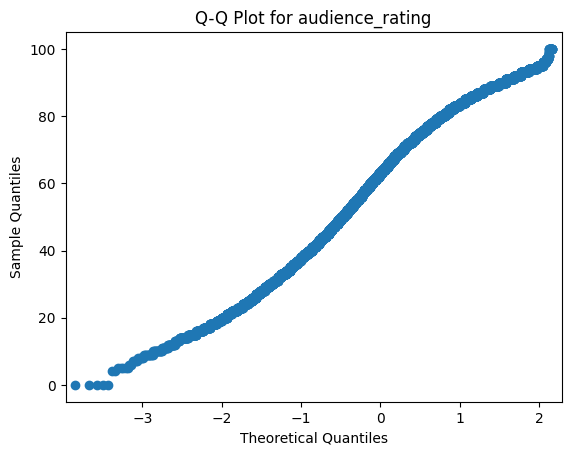

Shapiro-Wilk Test: Statistic=nan, p-value=nan
The data in 'audience_rating' does NOT appear Gaussian (reject H0).
D’Agostino-Pearson Test: Statistic=nan, p-value=nan
The data in 'audience_rating' does NOT appear Gaussian (reject H0).


In [20]:
check_normality(df, 'audience_rating')  # Replace with the column of interest

In [4]:
"""Preprocesses the data for training and prediction."""
# Drop irrelevant columns if needed (movie_title is not relevent and critic_consesnus is having almost 50% missing value of text data which can not add by ourself)
df.drop(columns=['movie_title'], inplace=True)
df.drop(columns=['critics_consensus'], inplace=True)

# Handle missing values by imputing or dropping
missingValueDropList = ['genre','directors','writers','cast', 'audience_rating']
for col in missingValueDropList:
    df.dropna(subset=[col], inplace=True)

convertingDate = ['in_theaters_date', 'on_streaming_date']
for col in convertingDate:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].dt.year

#filling some missing value withthe median
missingValueAVGFilling = ['runtime_in_minutes', 'in_theaters_date', 'on_streaming_date']
for col in missingValueAVGFilling:
  df[col].fillna(df[col].median(), inplace=True)
#filling missing value of studio_name with the most frequent studio_name
missingVAlueMostFreqFilling = ['studio_name']
for col in missingVAlueMostFreqFilling:
  most_frequent_value = df[col].mode()[0]
  df[col].fillna(most_frequent_value, inplace=True)

print("\nAfter handling missing values:")
print(df.isnull().sum())




After handling missing values:
movie_info            10
rating                 0
genre                  0
directors              0
writers                0
cast                   0
in_theaters_date       0
on_streaming_date      0
runtime_in_minutes     0
studio_name            0
tomatometer_status     0
tomatometer_rating     0
tomatometer_count      0
audience_rating        0
dtype: int64


In [22]:
df

,movie_info,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,A teenager discovers he's the descendant of a ...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010.0,2010,83.0,20th Century Fox,Rotten,49,144,53.0
1,Kate has a lot on her mind. There's the ethics...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010.0,2010,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,Blake Edwards' 10 stars Dudley Moore as George...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979.0,1997,118.0,Waner Bros.,Fresh,68,22,53.0
3,"A Puerto Rican youth is on trial for murder, a...",NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957.0,2001,95.0,Criterion Collection,Certified Fresh,100,51,97.0
4,"This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954.0,2003,127.0,Disney,Fresh,89,27,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,Former superhero Jack is called back to work t...,PG,"Action & Adventure, Comedy, Kids & Family",Peter Hewitt,"Adam Rifkin, David Berenbaum","Tim Allen, Courteney Cox, Chevy Chase, Spencer...",2006.0,2007,88.0,Sony Pictures Entertainment,Rotten,3,66,33.0
16633,"Based on a 1940s Los Angeles murder trial, thi...",R,"Drama, Musical & Performing Arts",Luis Valdez,Luis Valdez,"Daniel Valdez, Edward James Olmos, Charles Aid...",1981.0,2003,104.0,MCA Universal Home Video,Rotten,56,9,74.0
16634,The modern mammal metropolis of Zootopia is a ...,PG,"Action & Adventure, Animation, Comedy","Byron Howard, Rich Moore, Jared Bush","Jared Bush, Phil Johnston","Ginnifer Goodwin, Jason Bateman, Idris Elba, J...",2016.0,2016,108.0,Walt Disney Animation Studios,Certified Fresh,97,279,92.0
16636,"Filmed on a grand scale, Zulu is a rousing rec...",PG,"Classics, Drama","Cy Endfield, Cyril Endfield","Cy Endfield, John Prebble","Stanley Baker, Jack Hawkins, Ulla Jacobsson, J...",1964.0,2001,139.0,Paramount Pictures,Fresh,95,21,91.0


In [5]:
# Function: Target Encoding for High-Cardinality Columns
def target_encode_column(df, column_name, target_name):
    """Performs target encoding for high-cardinality categorical columns."""
    target_mean = df.groupby(column_name)[target_name].mean()
    df[column_name] = df[column_name].map(target_mean)
    print(f"'{column_name}' has been target-encoded based on '{target_name}'.")
    return df

# Function: TF-IDF Vectorization
def generate_bert_embeddings(df, text_column='movie_info', batch_size=32):
    """
    Converts a text column into BERT embeddings and replaces the column with embeddings.
    Args:
        df (pd.DataFrame): The input DataFrame.
        text_column (str): The name of the text column to convert.
        batch_size (int): Batch size for embedding generation.
    Returns:
        pd.DataFrame: Updated DataFrame with BERT embeddings replacing the original text column.
    """
    # Load Pre-trained BERT Model and Tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Function to calculate BERT embeddings
    def get_embeddings(text_list):
        embeddings = []
        for i in range(0, len(text_list), batch_size):
            batch = text_list[i:i+batch_size]
            # Convert batch elements to strings if they are not already
            batch = [str(text) for text in batch]  # This line ensures all elements are strings
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512)
            inputs = {key: val.to(device) for key, val in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)
                cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token embeddings

            embeddings.append(cls_embeddings)
        return np.vstack(embeddings)

    # Replace text column with BERT embeddings
    print("Generating BERT embeddings. This may take time...")
    text_data = df[text_column].fillna("Unknown").tolist()
    bert_embeddings = get_embeddings(text_data)

    # Add embeddings as new columns
    embedding_cols = [f"{text_column}_embed_{i}" for i in range(bert_embeddings.shape[1])]
    embeddings_df = pd.DataFrame(bert_embeddings, columns=embedding_cols)
    df = df.drop(columns=[text_column]).reset_index(drop=True)
    df = pd.concat([df, embeddings_df], axis=1)
    print("BERT embeddings generated and added to DataFrame.")
    return df
    def get_embeddings(text_list):
        """Helper function to compute BERT embeddings for a batch of text."""
        # Tokenize input text
        inputs = tokenizer(text_list, return_tensors='pt', padding=True, truncation=True, max_length=512)

        # Pass tokens through BERT model
        with torch.no_grad():
            outputs = model(**inputs)

        # Use the CLS token representation as the sentence embedding
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        return cls_embeddings.numpy()

    # Process the text column in batches for efficiency
    embeddings_list = []
    for i in range(0, len(df), batch_size):
        batch_text = df[column_name].iloc[i:i+batch_size].fillna('').tolist()
        batch_embeddings = get_embeddings(batch_text)
        embeddings_list.extend(batch_embeddings)

    # Replace the column with the BERT embeddings
    df[column_name] = embeddings_list
    print(f"'{column_name}' has been replaced with its BERT embeddings.")
    return df


# Function: Combine All Preprocessing Steps
def preprocess_data(df, target_column='audience_rating'):
    """Preprocesses data with TF-IDF, BERT embeddings, and target encoding."""
    # Target encode high-cardinality categorical columns
    if 'writers' in df.columns:
        df = target_encode_column(df, 'writers', target_column)
    if 'directors' in df.columns:
        df = target_encode_column(df, 'directors', target_column)

    # Process descriptions using TF-IDF
    # Process descriptions using TF-IDF
    # Process descriptions using BERT embeddings
    text_column = ['movie_info', 'cast']
    df_bert = df
    for col in text_column:
      df_bert = generate_bert_embeddings(df_bert, text_column=col)
      # Drop rows with missing target values
    #df_clean = df_bert.dropna(subset=[target_column])

    return df_bert


In [6]:
df_processed = preprocess_data(df)

'writers' has been target-encoded based on 'audience_rating'.
'directors' has been target-encoded based on 'audience_rating'.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Generating BERT embeddings. This may take time...
BERT embeddings generated and added to DataFrame.


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Generating BERT embeddings. This may take time...
BERT embeddings generated and added to DataFrame.


In [7]:
# List of columns to encode
encodingColumns = ['genre', 'studio_name']

# Apply One-Hot Encoding
df_processed = pd.get_dummies(df_processed, columns=encodingColumns, drop_first=True)

In [8]:
df_processed.head()

,rating,directors,writers,in_theaters_date,on_streaming_date,runtime_in_minutes,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,...,studio_name_Zweites Deutsches Fernsehen,studio_name_cinTBLAST!,studio_name_eOne,studio_name_eOne Entertainment,studio_name_eOne Entertainment Distribution,studio_name_eRealBiz,studio_name_iHQ,studio_name_levelFILM,studio_name_nWave Pictures,studio_name_s
0,PG,64.153846,53.000000,2010.0,2010,83.0,Rotten,49,144,53.0,...,False,False,False,False,False,False,False,False,False,False
1,R,59.400000,54.833333,2010.0,2010,90.0,Certified Fresh,86,140,64.0,...,False,False,False,False,False,False,False,False,False,False
2,R,62.346154,57.833333,1979.0,1997,118.0,Fresh,68,22,53.0,...,False,False,False,False,False,False,False,False,False,False
3,NR,65.034483,92.000000,1957.0,2001,95.0,Certified Fresh,100,51,97.0,...,False,False,False,False,False,False,False,False,False,False
4,G,63.466667,74.000000,1954.0,2003,127.0,Fresh,89,27,74.0,...,False,False,False,False,False,False,False,False,False,False


In [9]:
encodingColumns = ['rating', 'tomatometer_status']
ordinal_enc = OrdinalEncoder()
df_processed[encodingColumns] = ordinal_enc.fit_transform(df_processed[encodingColumns])

In [10]:
df_processed.columns

Index(['rating', 'directors', 'writers', 'in_theaters_date',
       'on_streaming_date', 'runtime_in_minutes', 'tomatometer_status',
       'tomatometer_rating', 'tomatometer_count', 'audience_rating',
       ...
       'studio_name_Zweites Deutsches Fernsehen', 'studio_name_cinTBLAST!',
       'studio_name_eOne', 'studio_name_eOne Entertainment',
       'studio_name_eOne Entertainment Distribution', 'studio_name_eRealBiz',
       'studio_name_iHQ', 'studio_name_levelFILM',
       'studio_name_nWave Pictures', 'studio_name_s'],
      dtype='object', length=5102)

In [11]:
scaler = StandardScaler()
numerical_cols = df_processed.select_dtypes(include=['float64', 'int64']).columns.drop('audience_rating')
df_processed[numerical_cols] = scaler.fit_transform(df_processed[numerical_cols])

print("\nData preprocessing completed.")


Data preprocessing completed.


In [73]:

# Function to make column names unique
def make_column_names_unique(df):
    # Keep track of the column names and their counts
    column_counts = {}
    
    # Iterate over the column names and add suffixes to duplicates
    new_columns = []
    for col in df.columns:
        if col in column_counts:
            column_counts[col] += 1
            new_column = f"{col}_{column_counts[col]}"  # Add suffix to duplicate column name
        else:
            column_counts[col] = 0
            new_column = col
        new_columns.append(new_column)
    
    # Update the dataframe with unique column names
    df.columns = new_columns
    return df

# Apply the function to make the column names unique
data_unique = make_column_names_unique(data_cleaned)

# Verify the updated column names
print("Unique column names:", data_unique.columns)

Unique column names: Index(['rating', 'directors', 'writers', 'in_theaters_date',
       'on_streaming_date', 'runtime_in_minutes', 'tomatometer_status',
       'tomatometer_rating', 'tomatometer_count', 'audience_rating',
       ...
       'studio_name_Zweites_Deutsches_Fernsehen', 'studio_name_cinTBLAST_',
       'studio_name_eOne', 'studio_name_eOne_Entertainment',
       'studio_name_eOne_Entertainment_Distribution', 'studio_name_eRealBiz',
       'studio_name_iHQ', 'studio_name_levelFILM',
       'studio_name_nWave_Pictures', 'studio_name_s'],
      dtype='object', length=5102)


In [77]:
import re
# Clean the column names
def clean_column_names(df):
    # Replace any invalid characters and spaces with underscores
    df.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in df.columns]
    return df

# Apply the cleaning function
data_cleaned = clean_column_names(df_processed)

# Verify the cleaned column names
print("Cleaned column names:", data_cleaned.columns)

Cleaned column names: Index(['rating', 'directors', 'writers', 'in_theaters_date',
       'on_streaming_date', 'runtime_in_minutes', 'tomatometer_status',
       'tomatometer_rating', 'tomatometer_count', 'audience_rating',
       ...
       'studio_name_Zweites_Deutsches_Fernsehen', 'studio_name_cinTBLAST_',
       'studio_name_eOne', 'studio_name_eOne_Entertainment',
       'studio_name_eOne_Entertainment_Distribution', 'studio_name_eRealBiz',
       'studio_name_iHQ', 'studio_name_levelFILM',
       'studio_name_nWave_Pictures', 'studio_name_s'],
      dtype='object', length=5102)


In [23]:
def split_data(df):
    """Splits the data into train and test sets."""
    X = df.drop(columns=['audience_rating'])
    y = df['audience_rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("\nData split into training and test sets.")
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

In [70]:
from xgboost import XGBRegressor
def train_model(X_train, y_train):
    """Trains a Random Forest model with Grid Search for hyperparameter tuning."""
    model = XGBRegressor(random_state=42, tree_method='gpu_hist', gpu_id=0)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100],
        'max_depth': [10],
        'learning_rate': [0.1],
        'subsample': [1.0]
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring='r2',cv=2, verbose=2, n_jobs=-1, error_score='raise')
    grid_search.fit(X_train, y_train)

    print("\nBest Parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    return best_model


In [75]:
def evaluate_model(model, X_test, y_test):
    """Evaluates the model performance on the test set."""
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    print("\nModel Evaluation:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, predictions, color='blue', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.xlabel("Actual Audience Rating")
    plt.ylabel("Predicted Audience Rating")
    plt.title("Actual vs Predicted Audience Rating")
    plt.show()

    import seaborn as sns
    plt.figure(figsize=(8, 6))
    sns.histplot(y_test - predictions, kde=True, color='blue')
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.title("Distribution of Prediction Errors")
    plt.show()

In [62]:
def main(df):
    X_train, X_test, y_train, y_test = split_data(df)
    model = train_model(X_train, y_train)
    evaluate_model(model, X_test, y_test)
    return model


Data split into training and test sets.
Train shape: (11968, 5101), Test shape: (2992, 5101)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:15:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:15:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Model Evaluation:
RMSE: 7.0570
R2 Score: 0.8813


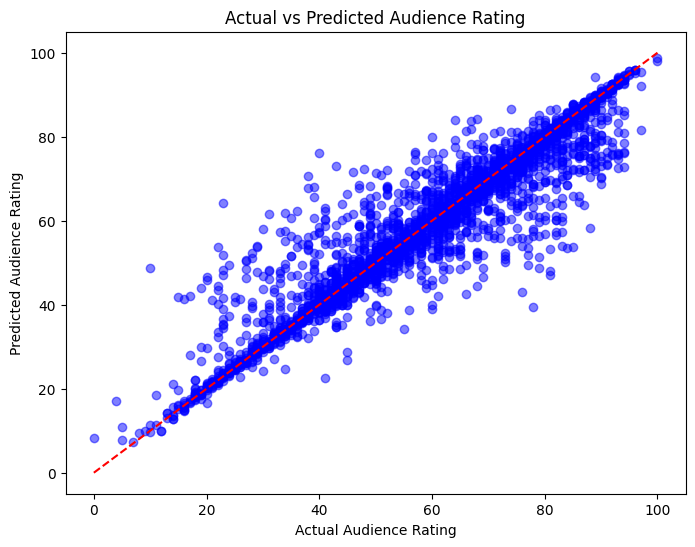

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


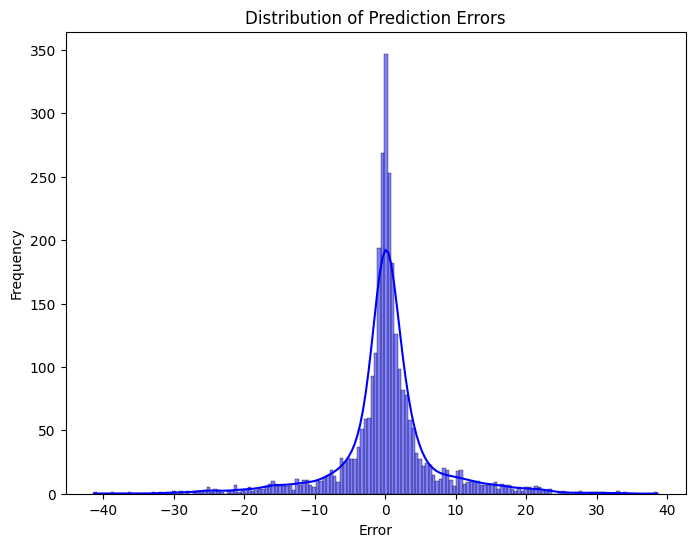

In [76]:
model = main(data_unique)

In [78]:
#Model is Trained with Accuracy 88%, which can be more increased as to added more parameter with the GridSearch
#and increased the CV to 3 or 5, but because of lack of resources i have to used these only,

#also we can use some more data preprocessing for more accurate model prediction like, gathering the missing
#data from the model, preprocess the Graph-Based Representation or Contextual Embeddings (Sentence Transformers)
#for individual cast importance and group dynamics and so on...

In [74]:
#for saving variables of the session
import dill
dill.dump_session('AudiencePricePrediction_RottenTomato_State.db')

In [51]:
#for loading the data back 
#import dill
#dill.load_session('AudiencePricePrediction_RottenTomato_State.db')